In [1]:
from evaluate_icsr_extraction import evaluate_icsr_from_dataset
from src import Icsr
from src.utils import get_matches
from datasets import load_dataset
from sklearn.metrics import classification_report


In [2]:
path = './generated_eval_predictions.txt'
dataset_name = 'FAERS-PubMed/BioDEX-ICSR'
dataset_split = 'validation'

preds = []
with open(path, 'r') as fp:
    preds = fp.readlines()

metrics = evaluate_icsr_from_dataset(preds, dataset_name, dataset_split)

Using custom data configuration FAERS-PubMed--BioDEX-ICSR-40aa49fec6af4868
Found cached dataset parquet (/Users/kldooste/.cache/huggingface/datasets/FAERS-PubMed___parquet/FAERS-PubMed--BioDEX-ICSR-40aa49fec6af4868/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
metrics

((65.14026699423484, 59.396820453657234, 61.42847740089519), 26)

## Seriousness metric

In [4]:
preds_icsr = [Icsr.from_string(p) for p in preds]
preds_serious = [i.serious if i else '1' for i in preds_icsr]

dataset = load_dataset(dataset_name)
gold_strings = dataset[dataset_split]["target"]
gold_icsr = [Icsr.from_string(p) for p in gold_strings]
gold_serious = [i.serious if i else '1' for i in gold_icsr]

Using custom data configuration FAERS-PubMed--BioDEX-ICSR-40aa49fec6af4868
Found cached dataset parquet (/Users/kldooste/.cache/huggingface/datasets/FAERS-PubMed___parquet/FAERS-PubMed--BioDEX-ICSR-40aa49fec6af4868/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
print(classification_report(gold_serious, preds_serious))

              precision    recall  f1-score   support

           1       0.95      0.98      0.96      2247
           2       0.43      0.23      0.30       160

    accuracy                           0.93      2407
   macro avg       0.69      0.60      0.63      2407
weighted avg       0.91      0.93      0.92      2407



In [6]:
print(classification_report(gold_serious, ['1'] * len(gold_serious)))

              precision    recall  f1-score   support

           1       0.93      1.00      0.97      2247
           2       0.00      0.00      0.00       160

    accuracy                           0.93      2407
   macro avg       0.47      0.50      0.48      2407
weighted avg       0.87      0.93      0.90      2407



/Users/kldooste/miniconda3/envs/biodex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kldooste/miniconda3/envs/biodex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kldooste/miniconda3/envs/biodex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [7]:
# The adverse event resulted in death, a life threatening condition, hospitalization, disability, congenital anomaly, or other serious condition"
def naive_baseline(fulltext):
    fulltext = fulltext.lower()
    if 'serious' in fulltext:
        return '1'
    elif 'death' in fulltext:
        return '1'
    elif 'hospitalization' in fulltext:
        return '1'
    elif 'threatening' in fulltext:
        return '1' 
    elif 'disability' in fulltext:
        return '1'
    elif 'anomaly' in fulltext:
        return '1'
    elif 'congenital' in fulltext:
        return '1'
    else:
        return '2'
    
naive_preds = [naive_baseline(f) for f in dataset[dataset_split]["fulltext_processed"]]
print(classification_report(gold_serious, naive_preds))

              precision    recall  f1-score   support

           1       0.94      0.64      0.76      2247
           2       0.08      0.42      0.13       160

    accuracy                           0.63      2407
   macro avg       0.51      0.53      0.45      2407
weighted avg       0.88      0.63      0.72      2407



### Do multiple reports per article share the seriousness value?

In [8]:
raw = load_dataset("FAERS-PubMed/raw_dataset")
matches = get_matches(raw['train'])

Using custom data configuration FAERS-PubMed--raw_dataset-0b83cc0b498dbbb2
Found cached dataset json (/Users/kldooste/.cache/huggingface/datasets/FAERS-PubMed___json/FAERS-PubMed--raw_dataset-0b83cc0b498dbbb2/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
uniform_seriousness = [len({r.serious for r in m.reports if r.serious != ''}) == 1 for m in matches]
print(100 * sum(uniform_seriousness) / len(uniform_seriousness))

95.91305142578601


## Triage per reaction

In [10]:
preds_icsr = [Icsr.from_string(p) for p in preds]

dataset = load_dataset(dataset_name)
gold_inputs = dataset[dataset_split]['fulltext_processed']
gold_strings = dataset[dataset_split]["target"]
gold_icsr = [Icsr.from_string(p) for p in gold_strings]

Using custom data configuration FAERS-PubMed--BioDEX-ICSR-40aa49fec6af4868
Found cached dataset parquet (/Users/kldooste/.cache/huggingface/datasets/FAERS-PubMed___parquet/FAERS-PubMed--BioDEX-ICSR-40aa49fec6af4868/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
# lower all predictions
for i in preds_icsr:
    if i:
        i.reactions = [r.lower() for r in i.reactions]
        i.drugs = [r.lower() for r in i.drugs]

for i in gold_icsr:
    if i:
        i.reactions = [r.lower() for r in i.reactions]
        i.drugs = [r.lower() for r in i.drugs]

In [12]:
def get_scores(target):
    pred_hits = []
    for icsr in preds_icsr:
        if icsr:
            pred_hits.append(target in icsr.reactions)
        else:
            pred_hits.append(False)

    gold_hits = []
    for icsr in gold_icsr:
        if icsr:
            gold_hits.append(target in icsr.reactions)
        else:
            gold_hits.append(False)

    naive_hits = []
    for text in gold_inputs:
        naive_hits.append(target in text.lower())

    pred_report = classification_report(gold_hits, pred_hits, output_dict=True)
    pred_f1 = pred_report['macro avg']['f1-score']
    naive_report = classification_report(gold_hits, naive_hits, output_dict=True)
    naive_f1 = naive_report['macro avg']['f1-score']

    return pred_f1, naive_f1


In [16]:
from collections import Counter
cutoff = 30
# principles way of selecting the targets
gold_reactions = [r for i in gold_icsr for r in i.reactions]
gold_reactions = Counter(gold_reactions)

gold_reactions = sorted(gold_reactions.items(), key=lambda x: x[1], reverse=True)[:cutoff]
gold_reactions_counts = [r[1] for r in gold_reactions]
gold_reactions = [r[0] for r in gold_reactions]

gold_drugs = [r for i in gold_icsr for r in i.drugs]
gold_drugs = Counter(gold_drugs)

gold_drugs = sorted(gold_drugs.items(), key=lambda x: x[1], reverse=True)[:cutoff]
gold_drugs_counts = [r[1] for r in gold_drugs]
gold_drugs = [r[0] for r in gold_drugs]

/Users/kldooste/miniconda3/envs/biodex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kldooste/miniconda3/envs/biodex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kldooste/miniconda3/envs/biodex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

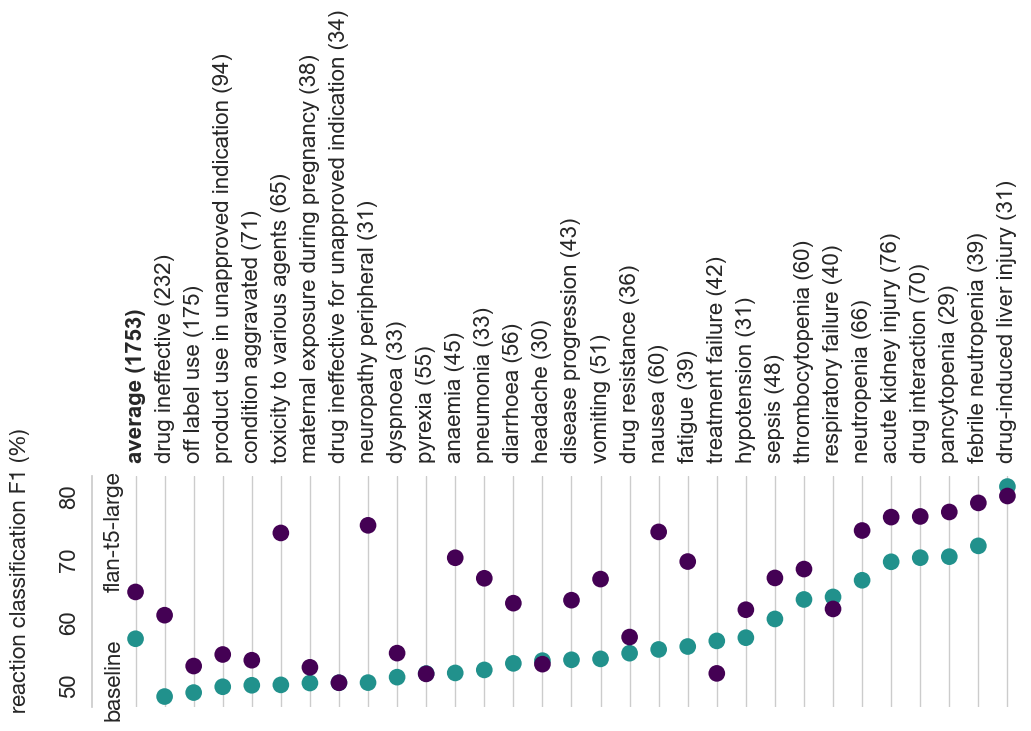

In [37]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")

# targets = sorted(['tuberculosis', 'pneumonia', 'covid-19', 'cardiac arrest', 'palpitations', 'ischaemic stroke', 'drug ineffective', 'hypersensitivity vasculitis', 'diffuse large b-cell lymphoma'])
targets = gold_reactions
counts = gold_reactions_counts
scores = [get_scores(t) for t in targets]
pred_scores = [s[0] for s in scores]
baseline_scores = [s[1] for s in scores]

# targets = [f'({c}) {t}' for t,c in zip(targets, counts)]
targets = [f'{t} ({c})' for t,c in zip(targets, counts)]


# Combine the data into a pandas DataFrame
data = pd.DataFrame({'scores': pred_scores + baseline_scores, 'model': ['flan-t5-large'] * len(pred_scores) + ['baseline'] * len(baseline_scores), 'targets': targets + targets})
data['scores'] = data['scores'] * 100
data = data.sort_values(by=['model', 'scores'], ascending=True )

# add average score
mean1 = data[data['model'] == 'baseline']['scores'].mean()
newline1 = pd.DataFrame({'model':'baseline', 'scores':mean1, 'targets':f'average ({sum(counts)})'}, index=[0])
mean2 = data[data['model'] == 'flan-t5-large']['scores'].mean()
newline2 = pd.DataFrame({'model':'flan-t5-large', 'scores':mean2, 'targets':f'average ({sum(counts)})'}, index=[0])
data = pd.concat([newline1, newline2, data.loc[:], ]).reset_index(drop=True)


fig, ax = plt.subplots(figsize=(12, 3))

# Get viridis color cycle
cmap = plt.get_cmap('viridis')
palette = [cmap(i) for i in np.linspace(0, 1, 3)][:2][::-1]

# sns.swarmplot(data=data, x='targets', y='scores', hue='model', s=12, orient='v', palette=palette)
sns.stripplot(data=data, x='targets', y='scores', hue='model', s=12, orient='v', palette=palette, jitter=False, dodge=False)

fontsize = 16


plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = fontsize



# Print the model labels on the dots
targets = data['targets'].unique()
data_indexed = data.set_index(['model', 'targets'])
plt.text(-1.1, data_indexed.loc['flan-t5-large', targets[0]][0], 'flan-t5-large',verticalalignment='bottom', rotation=90)
plt.text(-1.1, data_indexed.loc['baseline', targets[0]][0], 'baseline',verticalalignment='top', rotation=90)

ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True) # Show the vertical gridlines



sns.despine(bottom=True)
plt.yticks(rotation=90)
plt.tick_params(axis='x', labelbottom=False, labeltop=True, rotation=90)


# Format y-axis as percentages
# fmt = '%.0f%%'  # Format as whole numbers with percentage symbol
# yticks = mtick.FormatStrFormatter(fmt)
# plt.gca().yaxis.set_major_formatter(yticks)

# Annotate text on top of the y-axis
# highest_y = max(data['scores'])
# annotation_text = 'classification F1 (%)'
# plt.annotate(annotation_text, xy=(-.1, highest_y), xytext=(5, 0), rotation=90,
#              xycoords=('axes fraction', 'data'), textcoords='offset points',
#              ha='left', va='bottom')


# Add labels and title
plt.xlabel("")
ylabel = ax.set_ylabel("       reaction classification F1 (%)\n", fontfamily='Helvetica Neue', fontsize=fontsize)
ylabel.set_verticalalignment('bottom')

# Control font and font style for the axis tick labels
ax.tick_params(axis='both', which='major', labelsize=fontsize)
# plt.title("Drug classification ")

# plt.gca().invert_yaxis()  # Invert the y-axis to rotate the plot vertically
# plt.gca().invert_xaxis()  # Invert the x-axis to rotate the plot horizontal

# Remove the legend
ax.get_legend().remove()

# set the legend
# legend = plt.legend(frameon=False, fontsize=fontsize, markerscale=2, loc='upper left')

# Loop through all the legend elements
# for legend_element in legend.legendHandles:
    # legend_element.marker()
#     legend_element.set_visible(True)  # Make the marker visible
#     legend_element.set_linewidth(0)   # Remove the border around the marker
#     legend_element.set_markersize(12)  # Set the size of the marker


# Customize the legend labels
# labels = [text.get_text() for text in legend.get_texts()]  # Get the text labels
# for label in legend.get_texts():
#     label.set_fontsize(fontsize)  # Set the font size
#     label.set_fontfamily('Helvetica Neue')  # Set the font style


# for index, tick in enumerate(ax.xaxis.get_major_ticks()):
#       if index == 0:
#             tick.set_fontweight('bold')
#     #   tick.label1.set_fontsize(fontsize)

# Get the x-axis tick labels
tick_labels = plt.gca().get_xticklabels()

# Set the font weight for the first tick label
tick_labels[0].set_weight('bold')


# add space between bar and y=axis
left, right = plt.xlim()
plt.xlim((left-1, right))
plt.savefig('../../analysis/plots/reaction_classification.png', dpi=300, bbox_inches='tight')
plt.show()


from PIL import Image
# Open the PNG file
img = Image.open("../../analysis/plots/reaction_classification.png")

# Rotate the image by 90 degrees
img = img.rotate(270, expand=True)

# Overwrite the original file
img.save("../../analysis/plots/reaction_classification.png")



In [ ]:
# get occurance data for reactions using the training set?
dataset = load_dataset(dataset_name)
train_input = dataset['train']['fulltext_processed']
train_strings = dataset['train']["target"]
train_icsr = [Icsr.from_string(p) for p in train_strings]

Using custom data configuration FAERS-PubMed--BioDEX-ICSR-40aa49fec6af4868
Found cached dataset parquet (/Users/kldooste/.cache/huggingface/datasets/FAERS-PubMed___parquet/FAERS-PubMed--BioDEX-ICSR-40aa49fec6af4868/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
train_reactions = [r.lower() for i in train_icsr for r in i.reactions]

from collections import Counter
train_counts = sorted(list(Counter(train_reactions).items()), reverse=True, key=lambda x: x[1])


In [32]:
term_start = 0
term_end = 50

targets = [c[0] for c in train_counts][term_start:term_end]
scores = [get_scores(t) for t in targets]
pred_scores = [s[0] for s in scores]
baseline_scores = [s[1] for s in scores]

NameError: name 'train_counts' is not defined

/Users/kldooste/miniconda3/envs/biodex/lib/python3.9/site-packages/seaborn/categorical.py:3543: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/xp/33m08yl56t1f5z8g9s2h_1j80000gq/T/ipykernel_15824/1173494945.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels)
/Users/kldooste/miniconda3/envs/biodex/lib/python3.9/site-packages/seaborn/categorical.py:3543: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


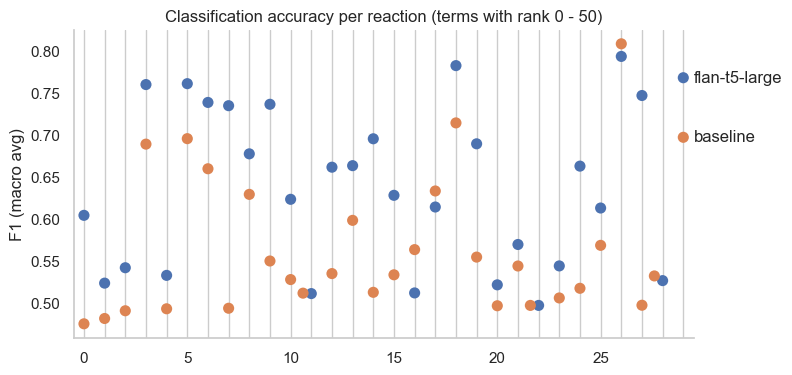

In [33]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Combine the data into a pandas DataFrame
# data = pd.DataFrame({'scores': pred_scores + baseline_scores, 'model': ['flan-t5-large'] * len(pred_scores) + ['baseline'] * len(baseline_scores), 'targets': targets + targets})
data = pd.DataFrame({'scores': pred_scores + baseline_scores, 'model': ['flan-t5-large'] * len(pred_scores) + ['baseline'] * len(baseline_scores), 'targets': list(range(len(pred_scores))) * 2})

fig, ax = plt.subplots(figsize=(8, 4))
sns.swarmplot(data=data, x='targets', y='scores', hue='model', s=8, orient='v') 

# Remove the legend
ax.get_legend().remove()

# Print the model labels on the dots
data_indexed = data.set_index(['model', 'targets'])
# plt.text(len(targets) - 0.9, data_indexed.loc['flan-t5-large', targets[-1]][0], 'flan-t5-large',verticalalignment='center')
# plt.text(len(targets) - 0.9, data_indexed.loc['baseline', targets[-1]][0], 'baseline',verticalalignment='center')
plt.text(len(targets) - 0.5, data_indexed.loc['flan-t5-large', len(targets)-1][0], 'flan-t5-large',verticalalignment='center')
plt.text(len(targets) - 0.5, data_indexed.loc['baseline', len(targets)-1][0], 'baseline',verticalalignment='center')


# set x-ticks at every 5th tick
ticks = ax.get_xticks()
# ax.set_xticks(ticks[::5])

# set tick labels for every non-fifth tick to an empty string
tick_labels = ['']*len(ticks)
tick_labels[::5] = [str(int(t)) for t in ticks[::5]]
ax.set_xticklabels(tick_labels)


ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True) # Show the vertical gridlines
sns.despine()


# Add labels and title
plt.xlabel("")
plt.ylabel("F1 (macro avg)")
plt.title(f"Classification accuracy per reaction (terms with rank {term_start} - {term_end})")
plt.show()


## Triage per drug

In [29]:
def get_drug_scores(target):
    pred_hits = []
    for icsr in preds_icsr:
        if icsr:
            pred_hits.append(target in icsr.drugs)
        else:
            pred_hits.append(False)

    gold_hits = []
    for icsr in gold_icsr:
        if icsr:
            gold_hits.append(target in icsr.drugs)
        else:
            gold_hits.append(False)

    naive_hits = []
    for text in gold_inputs:
        naive_hits.append(target in text.lower())

    pred_report = classification_report(gold_hits, pred_hits, output_dict=True)
    # print(classification_report(gold_hits, pred_hits, output_dict=False))
    pred_f1 = pred_report['macro avg']['f1-score']
    naive_report = classification_report(gold_hits, naive_hits, output_dict=True)
    # print(classification_report(gold_hits, naive_hits, output_dict=False))
    naive_f1 = naive_report['macro avg']['f1-score']

    return pred_f1, naive_f1


In [38]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

sns.set_theme(style="whitegrid")

# targets = sorted(['quetiapine','ibuprofen','calcium','efavirenz','prednisolone','aspirin', 'sodium chloride', 'hydroxocobalamin', 'infliximab'])
targets = gold_drugs
counts = gold_drugs_counts
scores = [get_drug_scores(t) for t in targets]
pred_scores = [s[0] for s in scores]
baseline_scores = [s[1] for s in scores]

targets = [f'{t} ({c})' for t,c in zip(targets, counts)]


# Combine the data into a pandas DataFrame
data = pd.DataFrame({'scores': pred_scores + baseline_scores, 'model': ['flan-t5-large'] * len(pred_scores) + ['baseline'] * len(baseline_scores), 'targets': targets + targets})
data['scores'] = data['scores'] * 100
data = data.sort_values(by=['model', 'scores'], ascending=True )

# add average score
mean1 = data[data['model'] == 'baseline']['scores'].mean()
newline1 = pd.DataFrame({'model':'baseline', 'scores':mean1, 'targets':f'average ({sum(counts)})'}, index=[0])
mean2 = data[data['model'] == 'flan-t5-large']['scores'].mean()
newline2 = pd.DataFrame({'model':'flan-t5-large', 'scores':mean2, 'targets':f'average ({sum(counts)})'}, index=[0])
data = pd.concat([newline1, newline2, data.loc[:], ]).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12, 3))

# Get viridis color cycle
cmap = plt.get_cmap('viridis')
palette = [cmap(i) for i in np.linspace(0, 1, 3)][:2][::-1]

# sns.swarmplot(data=data, x='targets', y='scores', hue='model', s=12, orient='v', palette=palette)
sns.stripplot(data=data, x='targets', y='scores', hue='model', s=12, orient='v', palette=palette, jitter=False)

plt.rcParams['font.family'] = 'Helvetica Neue'
fontsize = 16
plt.rcParams['font.size'] = fontsize

# Remove the legend
ax.get_legend().remove()

# Print the model labels on the dots
targets = data['targets'].unique()
data_indexed = data.set_index(['model', 'targets'])
plt.text(-1.1, data_indexed.loc['flan-t5-large', targets[0]][0], 'flan-t5-large',verticalalignment='bottom', rotation=90)
plt.text(-1.1, data_indexed.loc['baseline', targets[0]][0], 'baseline',verticalalignment='top', rotation=90)

ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True) # Show the vertical gridlines



sns.despine(bottom=True)
# plt.xticks(rotation=90, ha='center', va='top')
plt.yticks(rotation=90)

plt.tick_params(axis='x', labelbottom=False, labeltop=True, rotation=90)

# Format y-axis as percentages
# fmt = '%.0f%%'  # Format as whole numbers with percentage symbol
# yticks = mtick.FormatStrFormatter(fmt)
# plt.gca().yaxis.set_major_formatter(yticks)

# Annotate text on top of the y-axis
# highest_y = max(data['scores'])
# annotation_text = 'classification F1 (%)'
# plt.annotate(annotation_text, xy=(-.1, highest_y), xytext=(5, 0), rotation=90,
#              xycoords=('axes fraction', 'data'), textcoords='offset points',
#              ha='left', va='bottom')


# Add labels and title
plt.xlabel("")
ylabel = ax.set_ylabel("  drug classification F1 (%)\n", fontfamily='Helvetica Neue', fontsize=fontsize)
ylabel.set_verticalalignment('bottom')

# Control font and font style for the axis tick labels
ax.tick_params(axis='both', which='major', labelsize=fontsize)
# plt.title("Drug classification ")

# plt.gca().invert_yaxis()  # Invert the y-axis to rotate the plot vertically
# plt.gca().invert_xaxis()  # Invert the x-axis to rotate the plot horizontal

# Get the x-axis tick labels
tick_labels = plt.gca().get_xticklabels()

# Set the font weight for the first tick label
tick_labels[0].set_weight('bold')

# add space between bar and y=axis
left, right = plt.xlim()
plt.xlim((left-1, right))

plt.savefig('../../analysis/plots/drug_classification.png', dpi=300, bbox_inches='tight')
plt.show()

from PIL import Image
# Open the PNG file
img = Image.open("../../analysis/plots/drug_classification.png")

# Rotate the image by 90 degrees
img = img.rotate(270, expand=True)

# Overwrite the original file
img.save("../../analysis/plots/drug_classification.png")


## Generalization
Find drugs / reactions not mentioned in train and check how well the model performs at test time

In [72]:
for i in train_icsr:
    if i:
        i.reactions = [r.lower() for r in i.reactions]
        i.drugs = [r.lower() for r in i.drugs]

train_reactions = Counter([r for i in train_icsr for r in i.reactions])
val_reactions = Counter([r for i in gold_icsr for r in i.reactions])

val_reactions_not_in_train = {k:v for k,v in val_reactions.items() if k not in train_reactions}

In [77]:
top_new_reactions = sorted(val_reactions_not_in_train.items(), key=lambda x: x[1], reverse=True)
top_new_reactions = [r[0] for r in top_new_reactions][:10]

In [78]:
top_new_reactions

['administration site extravasation',
 'familial periodic paralysis',
 'international normalised ratio abnormal',
 'leishmaniasis',
 'uterine polyp',
 'urine osmolarity decreased',
 'alpha haemolytic streptococcal infection',
 'loss of proprioception',
 'meningoencephalitis viral',
 'encephalomalacia']

In [79]:
targets = top_new_reactions
scores = [get_scores(t) for t in targets]
pred_scores = [s[0] for s in scores]
baseline_scores = [s[1] for s in scores]

/Users/kldooste/miniconda3/envs/biodex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kldooste/miniconda3/envs/biodex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kldooste/miniconda3/envs/biodex/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

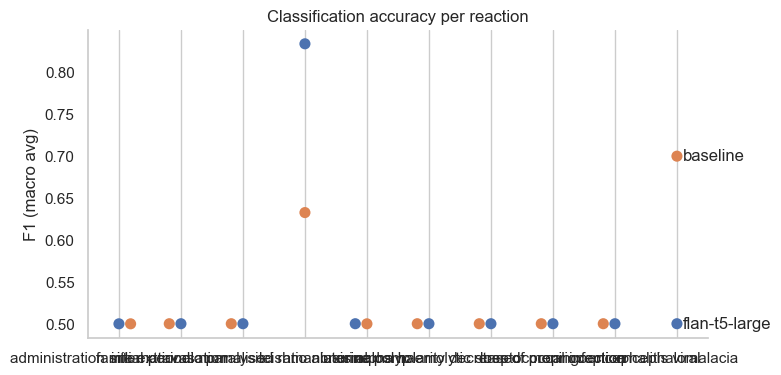

In [80]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Combine the data into a pandas DataFrame
data = pd.DataFrame({'scores': pred_scores + baseline_scores, 'model': ['flan-t5-large'] * len(pred_scores) + ['baseline'] * len(baseline_scores), 'targets': targets + targets})

fig, ax = plt.subplots(figsize=(8, 4))
sns.swarmplot(data=data, x='targets', y='scores', hue='model', s=8, orient='v') 

# Remove the legend
ax.get_legend().remove()

# Print the model labels on the dots
data_indexed = data.set_index(['model', 'targets'])
plt.text(len(targets) - 0.9, data_indexed.loc['flan-t5-large', targets[-1]][0], 'flan-t5-large',verticalalignment='center')
plt.text(len(targets) - 0.9, data_indexed.loc['baseline', targets[-1]][0], 'baseline',verticalalignment='center')

ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True) # Show the vertical gridlines

sns.despine()


# Add labels and title
plt.xlabel("")
plt.ylabel("F1 (macro avg)")
plt.title("Classification accuracy per reaction")
plt.show()
